In [ ]:
import numpy as np
import os
from pathlib import Path
import torch
import warnings

warnings.filterwarnings("ignore", )

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# PATH AND BASIC CONFIG

In [29]:
# Setting the root directory for data
ROOT_DATA_DIR = Path("/Volumes/Data_Bravo/Google_research_open_contrail")
TRAIN_DATA_DIR = ROOT_DATA_DIR / "train"
TEST_DATA_DIR = ROOT_DATA_DIR / "validation"

# Setting random seed for reproducibility
SEED = 19
torch.manual_seed(SEED)
np.random.seed(SEED)

# Setting MPS device to accelerate training
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    print("‚úÖ MPS device available, using it for training.")
else:
    print("‚ùå MPS device not available, using CPU.")

‚úÖ MPS device available, using it for training.


# DATA PREPROCESSING

In [30]:
# ============================
# Êï∞ÊçÆÈ¢ÑÂ§ÑÁêÜÂíåÂõæÂÉèÁîüÊàêÂ∑•ÂÖ∑ÂáΩÊï∞
# ============================

# Ê∏©Â∫¶ËåÉÂõ¥Â∏∏ÈáèÂÆö‰πâ - Áî®‰∫éÂç´ÊòüÂõæÂÉèÊï∞ÊçÆÁöÑÂΩí‰∏ÄÂåñ
# Ëøô‰∫õËåÉÂõ¥Âü∫‰∫éÂç´ÊòüÂõæÂÉè‰∏≠ÂêÑÊ≥¢ÊÆµÁöÑÁâ©ÁêÜÁâπÊÄßÂíåÁªèÈ™åÂÄº
_T11_BOUNDS = (243, 303)  # Band 11 Ê∏©Â∫¶ËåÉÂõ¥ (Kelvin)ÔºåÁî®‰∫éËìùËâ≤ÈÄöÈÅì
_CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)  # Band 14-11 Ê∏©Â∫¶Â∑ÆËåÉÂõ¥ÔºåÁî®‰∫éÁªøËâ≤ÈÄöÈÅìÔºåÂ∏ÆÂä©ËØÜÂà´‰∫ëÈ°∂ÁâπÂæÅ
_TDIFF_BOUNDS = (-4, 2)  # Band 15-14 Ê∏©Â∫¶Â∑ÆËåÉÂõ¥ÔºåÁî®‰∫éÁ∫¢Ëâ≤ÈÄöÈÅìÔºåÂ∏ÆÂä©Âå∫ÂàÜ‰∏çÂêåÁ±ªÂûãÁöÑ‰∫ëÂíåÈ£ûÊú∫Â∞æËøπ

def get_band_images(idx: str, parrent_folder: str, band: str) -> np.array:
    """
    ‰ªéÊåáÂÆöË∑ØÂæÑÂä†ËΩΩÂç´ÊòüÂõæÂÉèÁöÑÂçï‰∏™Ê≥¢ÊÆµÊï∞ÊçÆ
    
    Args:
        idx (str): Ê†∑Êú¨IDÔºåÂØπÂ∫îÊñá‰ª∂Â§πÂêçÁß∞
        parrent_folder (str): Áà∂Á∫ßÊñá‰ª∂Â§πÂêçÁß∞ ('train' Êàñ 'validation')
        band (str): Ê≥¢ÊÆµÁºñÂè∑ ('11', '14', '15' Á≠â)
    
    Returns:
        np.array: Âä†ËΩΩÁöÑÊ≥¢ÊÆµÊï∞ÊçÆÔºåÂΩ¢Áä∂ÈÄöÂ∏∏‰∏∫ (height, width, time_frames)
    """
    return np.load(
        os.path.join(ROOT_DATA_DIR, parrent_folder, idx, f'band_{band}.npy')
    )

def normalize_range(data, bounds):
    """
    Â∞ÜÊï∞ÊçÆÂΩí‰∏ÄÂåñÂà∞ [0, 1] ËåÉÂõ¥ÂÜÖ
    
    ‰∏∫‰ªÄ‰πàÈúÄË¶ÅÂΩí‰∏ÄÂåñÔºö
    1. ‰∏çÂêåÊ≥¢ÊÆµÁöÑÊï∞ÂÄºËåÉÂõ¥Â∑ÆÂºÇÂæàÂ§ßÔºåÂΩí‰∏ÄÂåñÂêé‰æø‰∫éÊ®°ÂûãÂ≠¶‰π†
    2. ÊúâÂä©‰∫éÊ¢ØÂ∫¶‰∏ãÈôçÁöÑÁ®≥ÂÆöÊÄßÂíåÊî∂ÊïõÈÄüÂ∫¶
    3. Èò≤Ê≠¢Êüê‰∫õÁâπÂæÅÂõ†Êï∞ÂÄºËøáÂ§ßËÄå‰∏ªÂØºÊ®°ÂûãÂ≠¶‰π†ËøáÁ®ã
    4. ‰ΩøÂæóRGBÂõæÂÉèÁöÑÊØè‰∏™ÈÄöÈÅìÈÉΩÂú®ÂêàÁêÜÁöÑÊòæÁ§∫ËåÉÂõ¥ÂÜÖ
    
    Args:
        data: ËæìÂÖ•Êï∞ÊçÆÊï∞ÁªÑ
        bounds: Êï∞ÊçÆÁöÑ (ÊúÄÂ∞èÂÄº, ÊúÄÂ§ßÂÄº) ÂÖÉÁªÑ
    
    Returns:
        ÂΩí‰∏ÄÂåñÂêéÁöÑÊï∞ÊçÆÔºåËåÉÂõ¥ [0, 1]
    
    Ê≥®ÊÑèÔºöË∂ÖÂá∫boundsËåÉÂõ¥ÁöÑÂÄº‰ºöË¢´Êò†Â∞ÑÂà∞ <0 Êàñ >1ÔºåÈÄöÂ∏∏ÈÖçÂêà np.clip ‰ΩøÁî®
    """
    return (data - bounds[0]) / (bounds[1] - bounds[0])


def get_ash_color_images(
    idx: str, parrent_folder: str, get_mask_frame_only=False
) -> np.array:
    """
    ÁîüÊàêÂÅáÂΩ©Ëâ≤ÂêàÊàêÂõæÂÉèÁî®‰∫éÈ£ûÊú∫Â∞æËøπÊ£ÄÊµã
    
    Ëøô‰∏™ÂáΩÊï∞ÂàõÂª∫‰∫Ü‰∏Ä‰∏™‰∏ìÈó®Áî®‰∫éÊ£ÄÊµãÈ£ûÊú∫Â∞æËøπÁöÑRGBÂÅáÂΩ©Ëâ≤ÂõæÂÉèÔºö
    - Á∫¢Ëâ≤ÈÄöÈÅì (R): Band 15-14 Ê∏©Â∫¶Â∑ÆÔºåÁ™ÅÂá∫ÊòæÁ§∫‰∏çÂêåÈ´òÂ∫¶ÁöÑ‰∫ëÂ±ÇÂ∑ÆÂºÇ
    - ÁªøËâ≤ÈÄöÈÅì (G): Band 14-11 Ê∏©Â∫¶Â∑ÆÔºåÂ∏ÆÂä©ËØÜÂà´‰∫ëÈ°∂Ê∏©Â∫¶ÁâπÂæÅ
    - ËìùËâ≤ÈÄöÈÅì (B): Band 14 ÁªùÂØπÊ∏©Â∫¶ÔºåÊèê‰æõÂü∫Á°ÄÊ∏©Â∫¶‰ø°ÊÅØ
    
    ‰∏∫‰ªÄ‰πà‰ΩøÁî®ÂÅáÂΩ©Ëâ≤Ôºö
    1. ‰∫∫ÁúºÊó†Ê≥ïÁõ¥Êé•ËßÇÂØüÁ∫¢Â§ñÊ≥¢ÊÆµÔºåÂÅáÂΩ©Ëâ≤Â∞Ü‰∏çÂèØËßÅ‰ø°ÊÅØËΩ¨Êç¢‰∏∫ÂèØËßÅ‰ø°ÊÅØ
    2. Ê∏©Â∫¶Â∑ÆÂºÇÊØîÁªùÂØπÊ∏©Â∫¶Êõ¥ËÉΩÁ™ÅÂá∫È£ûÊú∫Â∞æËøπÁöÑÁâπÂæÅ
    3. Â§öÊ≥¢ÊÆµÁªÑÂêàËÉΩÂ§üÂ¢ûÂº∫ÁõÆÊ†á‰∏éËÉåÊôØÁöÑÂØπÊØîÂ∫¶
    
    Args:
        idx (str): Ê†∑Êú¨ID
        parrent_folder (str): Êï∞ÊçÆÊñá‰ª∂Â§π ('train' Êàñ 'validation')
        get_mask_frame_only (bool): ÊòØÂê¶Âè™Ëé∑ÂèñmaskÂØπÂ∫îÁöÑÊó∂Èó¥Â∏ß (Á¨¨4Â∏ßÔºåÁ¥¢Âºï‰∏∫4)
    
    Returns:
        np.array: RGBÂÅáÂΩ©Ëâ≤ÂõæÂÉèÔºåÂΩ¢Áä∂‰∏∫ (height, width, 3) Êàñ (height, width, time_frames, 3)
                 Êï∞ÂÄºËåÉÂõ¥ [0, 1]
    """
    # Âä†ËΩΩ‰∏â‰∏™ÂÖ≥ÈîÆÁöÑÁ∫¢Â§ñÊ≥¢ÊÆµ
    band11 = get_band_images(idx, parrent_folder, '11')  # 8.6 Œºm Ê≥¢ÊÆµ
    band14 = get_band_images(idx, parrent_folder, '14')  # 11.2 Œºm Ê≥¢ÊÆµ  
    band15 = get_band_images(idx, parrent_folder, '15')  # 12.4 Œºm Ê≥¢ÊÆµ

    # Â¶ÇÊûúÂè™ÈúÄË¶ÅmaskÂØπÂ∫îÁöÑÊó∂Èó¥Â∏ßÔºåÂàôÊèêÂèñÁ¨¨4Â∏ß
    if get_mask_frame_only:
        band11 = band11[:, :, 4]
        band14 = band14[:, :, 4] 
        band15 = band15[:, :, 4]

    # ËÆ°ÁÆóÂÅáÂΩ©Ëâ≤ÈÄöÈÅì
    # Á∫¢Ëâ≤ÔºöBand 15-14 Â∑ÆÂÄºÔºåÁî®‰∫éÊ£ÄÊµãÂÜ∞Êô∂‰∫ëÁöÑÁâπÂæÅ
    r = normalize_range(band15 - band14, _TDIFF_BOUNDS)
    # ÁªøËâ≤ÔºöBand 14-11 Â∑ÆÂÄºÔºåÁî®‰∫éÊ£ÄÊµã‰∫ëÈ°∂È´òÂ∫¶ÂíåÊ∏©Â∫¶ÁâπÂæÅ
    g = normalize_range(band14 - band11, _CLOUD_TOP_TDIFF_BOUNDS)
    # ËìùËâ≤ÔºöBand 14 ÁªùÂØπÊ∏©Â∫¶ÔºåÊèê‰æõÂü∫Á°ÄÁÉ≠ËæêÂ∞Ñ‰ø°ÊÅØ
    b = normalize_range(band14, _T11_BOUNDS)
    
    # Â∞Ü‰∏â‰∏™ÈÄöÈÅìÂêàÂπ∂‰∏∫RGBÂõæÂÉèÔºåÂπ∂ÈôêÂà∂Âú® [0,1] ËåÉÂõ¥ÂÜÖ
    false_color = np.clip(np.stack([r, g, b], axis=2), 0, 1)
    return false_color

def get_mask_image(idx: str, parrent_folder: str) -> np.array:
    """
    Âä†ËΩΩ‰∫∫Â∑•Ê†áÊ≥®ÁöÑÂÉèÁ¥†Á∫ßÊé©Á†Å
    
    Args:
        idx (str): Ê†∑Êú¨ID
        parrent_folder (str): Êï∞ÊçÆÊñá‰ª∂Â§π
    
    Returns:
        np.array: ‰∫åÂÄºÊé©Á†ÅÔºå1Ë°®Á§∫È£ûÊú∫Â∞æËøπÂÉèÁ¥†Ôºå0Ë°®Á§∫ËÉåÊôØÂÉèÁ¥†
                 ÂΩ¢Áä∂ÈÄöÂ∏∏‰∏∫ (height, width, time_frames)
    """
    return np.load(
        os.path.join(ROOT_DATA_DIR, parrent_folder, idx, 'human_pixel_masks.npy')
    )

# MODEL SETUP

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchsummary import summary

# ============================
# U-Net ËØ≠‰πâÂàÜÂâ≤Ê®°ÂûãÂÆö‰πâ
# ============================

class DoubleConv(nn.Module):
    """
    U-Net‰∏≠ÁöÑÂèåÂç∑ÁßØÂùó - U-NetÁöÑÂü∫Á°ÄÊûÑÂª∫ÂçïÂÖÉ
    
    ÁªìÊûÑÔºöConv2d -> BatchNorm2d -> ReLU -> Conv2d -> BatchNorm2d -> ReLU
    
    ËÆæËÆ°ÂéüÁêÜÔºö
    1. ÂèåÂç∑ÁßØÂ¢ûÂä†ÁΩëÁªúÊ∑±Â∫¶ÔºåÊèêÈ´òÁâπÂæÅÊèêÂèñËÉΩÂäõ
    2. BatchNormÂä†ÈÄüËÆ≠ÁªÉÊî∂ÊïõÔºåÊèêÈ´òÊ®°ÂûãÁ®≥ÂÆöÊÄß
    3. ReLUÊøÄÊ¥ªÂáΩÊï∞Ëß£ÂÜ≥Ê¢ØÂ∫¶Ê∂àÂ§±ÈóÆÈ¢òÔºåÂ¢ûÂä†ÈùûÁ∫øÊÄß
    4. padding=1‰øùÊåÅÁâπÂæÅÂõæÂ∞∫ÂØ∏‰∏çÂèò
    
    Args:
        in_channels (int): ËæìÂÖ•ÈÄöÈÅìÊï∞
        out_channels (int): ËæìÂá∫ÈÄöÈÅìÊï∞
    """
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            # Á¨¨‰∏Ä‰∏™Âç∑ÁßØÂ±ÇÔºöÊèêÂèñÂ±ÄÈÉ®ÁâπÂæÅ
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),  # ÊâπÂΩí‰∏ÄÂåñÔºöÁ®≥ÂÆöËÆ≠ÁªÉÔºåÂä†ÈÄüÊî∂Êïõ
            nn.ReLU(inplace=True),         # ÈùûÁ∫øÊÄßÊøÄÊ¥ª
            
            # Á¨¨‰∫å‰∏™Âç∑ÁßØÂ±ÇÔºöËøõ‰∏ÄÊ≠•ÁªÜÂåñÁâπÂæÅ
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """
    U-NetÁºñÁ†ÅÂô®ÁöÑ‰∏ãÈááÊ†∑Âùó
    
    ÁªìÊûÑÔºöMaxPool2d -> DoubleConv
    
    ÂäüËÉΩÔºö
    1. MaxPool2dÔºöÂ∞ÜÁâπÂæÅÂõæÂ∞∫ÂØ∏ÂáèÂçäÔºåÊâ©Â§ßÊÑüÂèóÈáé
    2. DoubleConvÔºöÊèêÂèñÊõ¥È´òÁ∫ßÁöÑËØ≠‰πâÁâπÂæÅ
    
    Âú®ÁºñÁ†ÅÂô®Ë∑ØÂæÑ‰∏≠Ôºö
    - ÈÄêÊ∏êÂáèÂ∞èÁ©∫Èó¥ÂàÜËæ®Áéá (H, W)
    - ÈÄêÊ∏êÂ¢ûÂä†ÁâπÂæÅÈÄöÈÅìÊï∞ (C)
    - ÊçïËé∑Êõ¥Â§ßËåÉÂõ¥ÁöÑ‰∏ä‰∏ãÊñá‰ø°ÊÅØ
    """
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),  # 2x2ÊúÄÂ§ßÊ±†ÂåñÔºåÂ∞∫ÂØ∏ÂáèÂçä
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """
    U-NetËß£Á†ÅÂô®ÁöÑ‰∏äÈááÊ†∑Âùó
    
    ÂäüËÉΩÔºö
    1. ‰∏äÈááÊ†∑ÔºöÊÅ¢Â§çÁ©∫Èó¥ÂàÜËæ®Áéá
    2. Ë∑≥Ë∑ÉËøûÊé•ÔºöËûçÂêàÁºñÁ†ÅÂô®ÁöÑ‰ΩéÁ∫ßÁâπÂæÅÂíåËß£Á†ÅÂô®ÁöÑÈ´òÁ∫ßÁâπÂæÅ
    3. ÂèåÂç∑ÁßØÔºöÊï¥ÂêàÂ§öÂ∞∫Â∫¶ÁâπÂæÅ
    
    Ë∑≥Ë∑ÉËøûÊé•ÁöÑÈáçË¶ÅÊÄßÔºö
    - ‰øùÁïôÁªÜËäÇ‰ø°ÊÅØÔºöÁºñÁ†ÅÂô®ÁöÑÊµÖÂ±ÇÁâπÂæÅÂåÖÂê´‰∏∞ÂØåÁöÑÁ©∫Èó¥ÁªÜËäÇ
    - Ê¢ØÂ∫¶ÊµÅÈÄöÔºöÂ∏ÆÂä©Ê¢ØÂ∫¶Êõ¥Â•ΩÂú∞ÂèçÂêë‰º†Êí≠
    - Â§öÂ∞∫Â∫¶ËûçÂêàÔºöÁªìÂêà‰∏çÂêåÂ±ÇÊ¨°ÁöÑÁâπÂæÅË°®Á§∫
    """
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up, self).__init__()

        if bilinear:
            # ÂèåÁ∫øÊÄßÊèíÂÄº‰∏äÈááÊ†∑ÔºöËÆ°ÁÆóÊïàÁéáÈ´òÔºåÂèÇÊï∞Â∞ë
            self.up = nn.Upsample(
                scale_factor=2, mode='bilinear', align_corners=True
            )
        else:
            # ËΩ¨ÁΩÆÂç∑ÁßØ‰∏äÈááÊ†∑ÔºöÂèØÂ≠¶‰π†ÁöÑ‰∏äÈááÊ†∑Ôºå‰ΩÜÂèÇÊï∞Êõ¥Â§ö
            self.up = nn.ConvTranspose2d(
                in_channels // 2, in_channels // 2, kernel_size=2, stride=2
            )

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        """
        Args:
            x1: Êù•Ëá™‰∏ä‰∏ÄÂ±ÇËß£Á†ÅÂô®ÁöÑÁâπÂæÅ (‰ΩéÂàÜËæ®ÁéáÔºåÈ´òËØ≠‰πâ)
            x2: Êù•Ëá™ÁºñÁ†ÅÂô®Ë∑≥Ë∑ÉËøûÊé•ÁöÑÁâπÂæÅ (È´òÂàÜËæ®ÁéáÔºå‰ΩéËØ≠‰πâ)
        """
        # ‰∏äÈááÊ†∑x1Âà∞‰∏éx2Áõ∏ÂêåÁöÑÁ©∫Èó¥Â∞∫ÂØ∏
        x1 = self.up(x1)

        # Â§ÑÁêÜÂ∞∫ÂØ∏‰∏çÂåπÈÖçÈóÆÈ¢òÔºàÁî±‰∫éÊ±†ÂåñÂèØËÉΩÂØºËá¥ÁöÑÂ∞∫ÂØ∏‰∏çÂÆåÂÖ®ÂåπÈÖçÔºâ
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        # ÂØπx1ËøõË°åpadding‰ª•ÂåπÈÖçx2ÁöÑÂ∞∫ÂØ∏
        x1 = nn.functional.pad(
            x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2]
        )

        # Ë∑≥Ë∑ÉËøûÊé•ÔºöÂú®ÈÄöÈÅìÁª¥Â∫¶‰∏äËøûÊé•‰∏§‰∏™ÁâπÂæÅÂõæ
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class UNet(nn.Module):
    """
    U-NetËØ≠‰πâÂàÜÂâ≤ÁΩëÁªú
    
    ÁΩëÁªúÊû∂ÊûÑÔºö
    1. ÁºñÁ†ÅÂô®Ë∑ØÂæÑ (Êî∂Áº©Ë∑ØÂæÑ)Ôºö
       - ÈÄêÂ±Ç‰∏ãÈááÊ†∑ÔºåÊèêÂèñÂ§öÂ∞∫Â∫¶ÁâπÂæÅ
       - ÈÄöÈÅìÊï∞ÈÄíÂ¢ûÔºö3‚Üí64‚Üí128‚Üí256‚Üí512‚Üí512
       - Á©∫Èó¥Â∞∫ÂØ∏ÈÄíÂáèÔºö256√ó256‚Üí128√ó128‚Üí64√ó64‚Üí32√ó32‚Üí16√ó16‚Üí8√ó8
    
    2. Ëß£Á†ÅÂô®Ë∑ØÂæÑ (Êâ©Âº†Ë∑ØÂæÑ)Ôºö
       - ÈÄêÂ±Ç‰∏äÈááÊ†∑ÔºåÊÅ¢Â§çÁ©∫Èó¥ÂàÜËæ®Áéá
       - Ë∑≥Ë∑ÉËøûÊé•ËûçÂêàÁºñÁ†ÅÂô®ÁâπÂæÅ
       - ÈÄöÈÅìÊï∞ÈÄíÂáèÔºö1024‚Üí512‚Üí256‚Üí128‚Üí64
       - Á©∫Èó¥Â∞∫ÂØ∏ÈÄíÂ¢ûÔºö8√ó8‚Üí16√ó16‚Üí32√ó32‚Üí64√ó64‚Üí128√ó128‚Üí256√ó256
    
    3. ËæìÂá∫Â±ÇÔºö
       - 1√ó1Âç∑ÁßØÂ∞Ü64ÈÄöÈÅìÁâπÂæÅÊò†Â∞ÑÂà∞1ÈÄöÈÅì
       - ËæìÂá∫ÊØè‰∏™ÂÉèÁ¥†Â±û‰∫éÈ£ûÊú∫Â∞æËøπÁöÑÊ¶ÇÁéálogits
    
    ËæìÂÖ•Ôºö(batch_size, 24, 256, 256) - 24ÈÄöÈÅìÂÅáÂΩ©Ëâ≤ÂõæÂÉèÂ∫èÂàó
    ËæìÂá∫Ôºö(batch_size, 1, 256, 256) - ÂçïÈÄöÈÅìÂàÜÂâ≤Êé©Á†Å
    
    ÈÄÇÁî®‰∫éÈ£ûÊú∫Â∞æËøπÊ£ÄÊµãÁöÑÂéüÂõ†Ôºö
    1. ‰øùÊåÅÁ©∫Èó¥ÁªÜËäÇÔºöË∑≥Ë∑ÉËøûÊé•‰øùÁïô‰∫ÜÂÉèÁ¥†Á∫ßÁ≤æÂ∫¶
    2. Â§öÂ∞∫Â∫¶ÁâπÂæÅÔºöËÉΩÂ§üÊçïËé∑‰∏çÂêåÂ∞∫Â∫¶ÁöÑÂ∞æËøπÂΩ¢Áä∂
    3. ‰∏ä‰∏ãÊñá‰ø°ÊÅØÔºöÁºñÁ†ÅÂô®Êèê‰æõË∂≥Â§üÁöÑÊÑüÂèóÈáé
    """
    def __init__(self):
        super(UNet, self).__init__()
        
        # ÁºñÁ†ÅÂô®Ë∑ØÂæÑ (‰∏ãÈááÊ†∑)
        self.inc = DoubleConv(24, 64)    # ÂàùÂßãÂç∑ÁßØÔºö24‚Üí64ÈÄöÈÅì
        self.down1 = Down(64, 128)       # Á¨¨1Ê¨°‰∏ãÈááÊ†∑Ôºö64‚Üí128ÈÄöÈÅì
        self.down2 = Down(128, 256)      # Á¨¨2Ê¨°‰∏ãÈááÊ†∑Ôºö128‚Üí256ÈÄöÈÅì  
        self.down3 = Down(256, 512)      # Á¨¨3Ê¨°‰∏ãÈááÊ†∑Ôºö256‚Üí512ÈÄöÈÅì
        self.down4 = Down(512, 512)      # Á¨¨4Ê¨°‰∏ãÈááÊ†∑Ôºö512‚Üí512ÈÄöÈÅì (Áì∂È¢àÂ±Ç)
        
        # Ëß£Á†ÅÂô®Ë∑ØÂæÑ (‰∏äÈááÊ†∑)
        self.up1 = Up(1024, 256)         # Á¨¨1Ê¨°‰∏äÈááÊ†∑Ôºö1024‚Üí256ÈÄöÈÅì (512+512Ë∑≥Ë∑ÉËøûÊé•)
        self.up2 = Up(512, 128)          # Á¨¨2Ê¨°‰∏äÈááÊ†∑Ôºö512‚Üí128ÈÄöÈÅì (256+256Ë∑≥Ë∑ÉËøûÊé•)
        self.up3 = Up(256, 64)           # Á¨¨3Ê¨°‰∏äÈááÊ†∑Ôºö256‚Üí64ÈÄöÈÅì (128+128Ë∑≥Ë∑ÉËøûÊé•)
        self.up4 = Up(128, 64)           # Á¨¨4Ê¨°‰∏äÈááÊ†∑Ôºö128‚Üí64ÈÄöÈÅì (64+64Ë∑≥Ë∑ÉËøûÊé•)
        
        # ËæìÂá∫Â±ÇÔºöÂ∞Ü64ÈÄöÈÅìÁâπÂæÅÊò†Â∞Ñ‰∏∫1ÈÄöÈÅìÂàÜÂâ≤ÁªìÊûú
        self.outc = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        """
        ÂâçÂêë‰º†Êí≠ËøáÁ®ã
        
        Args:
            x: ËæìÂÖ•Âº†Èáè (batch_size, 24, 256, 256)
            
        Returns:
            ËæìÂá∫Âº†Èáè (batch_size, 1, 256, 256) - ÂàÜÂâ≤logits
        """
        # ÁºñÁ†ÅÂô®Ë∑ØÂæÑÔºöÈÄêÂ±ÇÊèêÂèñÁâπÂæÅÂπ∂‰øùÂ≠òË∑≥Ë∑ÉËøûÊé•
        x1 = self.inc(x)      # [B, 64, 256, 256]
        x2 = self.down1(x1)   # [B, 128, 128, 128]  
        x3 = self.down2(x2)   # [B, 256, 64, 64]
        x4 = self.down3(x3)   # [B, 512, 32, 32]
        x5 = self.down4(x4)   # [B, 512, 16, 16]
        
        # Ëß£Á†ÅÂô®Ë∑ØÂæÑÔºöÈÄêÂ±Ç‰∏äÈááÊ†∑Âπ∂ËûçÂêàË∑≥Ë∑ÉËøûÊé•
        x = self.up1(x5, x4)  # [B, 256, 32, 32]
        x = self.up2(x, x3)   # [B, 128, 64, 64]
        x = self.up3(x, x2)   # [B, 64, 128, 128]  
        x = self.up4(x, x1)   # [B, 64, 256, 256]
        
        # ËæìÂá∫Â±ÇÔºöÁîüÊàêÊúÄÁªàÁöÑÂàÜÂâ≤Êé©Á†Å
        x = self.outc(x)      # [B, 1, 256, 256]
        return x

In [32]:
# ÂàõÂª∫Ê®°ÂûãÂπ∂Â∞ÜÂÖ∂ÁßªÂä®Âà∞MPSËÆæÂ§á
model = UNet()

summary(model, input_size=(24, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]          13,888
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
        DoubleConv-7         [-1, 64, 256, 256]               0
         MaxPool2d-8         [-1, 64, 128, 128]               0
            Conv2d-9        [-1, 128, 128, 128]          73,856
      BatchNorm2d-10        [-1, 128, 128, 128]             256
             ReLU-11        [-1, 128, 128, 128]               0
           Conv2d-12        [-1, 128, 128, 128]         147,584
      BatchNorm2d-13        [-1, 128, 128, 128]             256
             ReLU-14        [-1, 128, 1

# TRAINNER

In [33]:
# ============================
# ÊçüÂ§±ÂáΩÊï∞ÂÆö‰πâ
# ============================

class Dice(nn.Module):
    """
    DiceÁ≥ªÊï∞ÔºàS√∏rensen-DiceÁ≥ªÊï∞Ôºâ- ËØ≠‰πâÂàÜÂâ≤‰∏≠ÁöÑÈáçË¶ÅËØÑ‰º∞ÊåáÊ†á
    
    DiceÁ≥ªÊï∞ÂÖ¨ÂºèÔºöDice = 2√ó|A‚à©B| / (|A| + |B|)
    ÂÖ∂‰∏≠Ôºö
    - A: È¢ÑÊµãÁöÑÊ≠£‰æãÂÉèÁ¥†ÈõÜÂêà
    - B: ÁúüÂÆûÁöÑÊ≠£‰æãÂÉèÁ¥†ÈõÜÂêà  
    - |A‚à©B|: È¢ÑÊµãÂíåÁúüÂÆûÈÉΩ‰∏∫Ê≠£‰æãÁöÑÂÉèÁ¥†Êï∞ÈáèÔºàÁúüÊ≠£‰æãÔºâ
    - |A|: È¢ÑÊµã‰∏∫Ê≠£‰æãÁöÑÂÉèÁ¥†ÊÄªÊï∞
    - |B|: ÁúüÂÆûÊ≠£‰æãÁöÑÂÉèÁ¥†ÊÄªÊï∞
    
    ‰∏∫‰ªÄ‰πà‰ΩøÁî®DiceÁ≥ªÊï∞Ôºö
    1. Á±ªÂà´‰∏çÂπ≥Ë°°Â§ÑÁêÜÔºöÈ£ûÊú∫Â∞æËøπÂÉèÁ¥†ÈÄöÂ∏∏Âè™Âç†ÂõæÂÉèÁöÑÂæàÂ∞èÈÉ®ÂàÜÔºåDiceÁ≥ªÊï∞ÂØπÊ≠£‰æãÊõ¥ÊïèÊÑü
    2. ÈáçÂè†Â∫¶ÈáèÔºöÁõ¥Êé•Ë°°ÈáèÈ¢ÑÊµãÂå∫Âüü‰∏éÁúüÂÆûÂå∫ÂüüÁöÑÈáçÂè†Á®ãÂ∫¶ÔºåÁ¨¶ÂêàÂàÜÂâ≤‰ªªÂä°ÁöÑËØÑ‰º∞ÈúÄÊ±Ç
    3. ÂèØÂæÆÂàÜÔºöÂèØ‰ª•‰Ωú‰∏∫ÊçüÂ§±ÂáΩÊï∞ËøõË°åÂèçÂêë‰º†Êí≠ËÆ≠ÁªÉ
    4. ËåÉÂõ¥ [0,1]Ôºö1Ë°®Á§∫ÂÆåÁæéÈáçÂè†Ôºå0Ë°®Á§∫ÂÆåÂÖ®‰∏çÈáçÂè†
    
    ‰∏éÂÖ∂‰ªñÊåáÊ†áÁöÑÊØîËæÉÔºö
    - ÂáÜÁ°ÆÁéá (Accuracy): Âú®ÊûÅ‰∏çÂπ≥Ë°°Êï∞ÊçÆ‰∏≠ÂÆπÊòìË¢´ËÉåÊôØÂÉèÁ¥†‰∏ªÂØº
    - IoU (Intersection over Union): ‰∏éDiceÁõ∏ÂÖ≥Ôºå‰ΩÜDiceÂØπÂ∞èÁõÆÊ†áÊõ¥ÂèãÂ•Ω
    - ‰∫§ÂèâÁÜµÊçüÂ§±: ÈÄêÂÉèÁ¥†ËÆ°ÁÆóÔºå‰∏çËÄÉËôëÂå∫ÂüüÁöÑËøûÈÄöÊÄß
    
    Args:
        use_sigmoid (bool): ÊòØÂê¶ÂØπËæìÂÖ•Â∫îÁî®sigmoidÊøÄÊ¥ª
                           True: ËæìÂÖ•‰∏∫logitsÔºåÈúÄË¶ÅËΩ¨Êç¢‰∏∫Ê¶ÇÁéá
                           False: ËæìÂÖ•Â∑≤ÁªèÊòØÊ¶ÇÁéáÂÄº
    """
    def __init__(self, use_sigmoid=True):
        super(Dice, self).__init__()
        self.sigmoid = nn.Sigmoid()
        self.use_sigmoid = use_sigmoid

    def forward(self, inputs, targets, smooth=1):
        """
        ËÆ°ÁÆóDiceÁ≥ªÊï∞
        
        Args:
            inputs: Ê®°ÂûãÈ¢ÑÊµãËæìÂá∫ (batch_size, 1, H, W)
                   Â¶ÇÊûúuse_sigmoid=TrueÔºåÂàô‰∏∫logitsÔºõÂê¶Âàô‰∏∫Ê¶ÇÁéá
            targets: ÁúüÂÆûÊ†áÁ≠æ (batch_size, 1, H, W)Ôºå‰∫åÂÄºÊé©Á†ÅÔºå0Êàñ1
            smooth: Âπ≥ÊªëÂ∏∏Êï∞ÔºåÈò≤Ê≠¢ÂàÜÊØç‰∏∫0ÔºåÊèêÈ´òÊï∞ÂÄºÁ®≥ÂÆöÊÄß
                   ËæÉÂ∞èÁöÑsmoothÂÄº‰ΩøÂæóDiceÂØπÂ∞èÁõÆÊ†áÊõ¥ÊïèÊÑü
        
        Returns:
            dice: DiceÁ≥ªÊï∞ÔºåËåÉÂõ¥ [0, 1]
        
        ËÆ°ÁÆóÁªÜËäÇÔºö
        1. Â∞ÜÂ§öÁª¥Âº†ÈáèÂ±ïÂπ≥‰∏∫‰∏ÄÁª¥Ôºå‰æø‰∫éËÆ°ÁÆó‰∫§ÈõÜÂíåÂπ∂ÈõÜ
        2. ËÆ°ÁÆóintersectionÔºöÈ¢ÑÊµãÂíåÁúüÂÆûÈÉΩ‰∏∫Ê≠£ÁöÑÂÉèÁ¥†Êï∞Èáè
        3. Â∫îÁî®DiceÂÖ¨ÂºèÔºåÂä†ÂÖ•Âπ≥ÊªëÈ°πÈÅøÂÖçÈô§Èõ∂ÈîôËØØ
        """
        # Â¶ÇÊûúËæìÂÖ•ÊòØlogitsÔºåËΩ¨Êç¢‰∏∫Ê¶ÇÁéá
        if self.use_sigmoid:
            inputs = self.sigmoid(inputs)

        # Â∞ÜÂº†ÈáèÂ±ïÂπ≥‰∏∫‰∏ÄÁª¥ÂêëÈáèÔºå‰æø‰∫éËÆ°ÁÆóÂÉèÁ¥†Á∫ßÁöÑ‰∫§ÈõÜ
        # ÂéüÂßãÂΩ¢Áä∂Ôºö(batch_size, 1, H, W) -> Â±ïÂπ≥ÂêéÔºö(batch_size * H * W)
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        # ËÆ°ÁÆó‰∫§ÈõÜÔºöÈ¢ÑÊµã‰∏∫Ê≠£‰∏îÁúüÂÆû‰∏∫Ê≠£ÁöÑÂÉèÁ¥†Êï∞Èáè
        # inputs * targets: ÈÄêÂÖÉÁ¥†Áõ∏‰πòÔºåÂè™ÊúâÈÉΩ‰∏∫1Êó∂ÁªìÊûúÊâç‰∏∫1
        intersection = (inputs * targets).sum()
        
        # Â∫îÁî®DiceÂÖ¨Âºè
        # ÂàÜÂ≠êÔºö2 * ‰∫§ÈõÜ + Âπ≥ÊªëÈ°π
        # ÂàÜÊØçÔºöÈ¢ÑÊµãÊ≠£‰æãÊÄªÊï∞ + ÁúüÂÆûÊ≠£‰æãÊÄªÊï∞ + Âπ≥ÊªëÈ°π
        dice = (2.0 * intersection + smooth) / (
            inputs.sum() + targets.sum() + smooth
        )

        return dice


# ÂÆû‰æãÂåñDiceËØÑ‰º∞Âô®
# Ê≥®ÊÑèÔºöËøôÈáåÂàõÂª∫ÁöÑÊòØËØÑ‰º∞ÊåáÊ†áÔºå‰∏çÊòØÊçüÂ§±ÂáΩÊï∞
# ËÆ≠ÁªÉÊó∂ÈÄöÂ∏∏‰ΩøÁî® 1 - Dice ‰Ωú‰∏∫ÊçüÂ§±ÂáΩÊï∞ÔºåÊàñ‰ΩøÁî®‰∏ìÈó®ÁöÑDiceLoss
dice = Dice()

In [34]:
import os
from torch.amp import autocast

torch.set_autocast_enabled(True)

# ============================
# Ê®°ÂûãËÆ≠ÁªÉÂô®Á±ª
# ============================


class MyTrainer:
    """
    Ëá™ÂÆö‰πâËÆ≠ÁªÉÂô®Á±ª - Â∞ÅË£ÖÊ∑±Â∫¶Â≠¶‰π†Ê®°ÂûãÁöÑËÆ≠ÁªÉÂíåÈ™åËØÅÊµÅÁ®ã

    ÂäüËÉΩÁâπÊÄßÔºö
    1. ËÆ≠ÁªÉÂæ™ÁéØÁÆ°ÁêÜÔºöËá™Âä®ÂåñepochÂíåbatchÁöÑËø≠‰ª£
    2. ÊçüÂ§±ËÆ∞ÂΩïÔºöË∑üË∏™ËÆ≠ÁªÉÂíåÈ™åËØÅÊçüÂ§±ÁöÑÂèòÂåñË∂ãÂäø
    3. Â≠¶‰π†ÁéáË∞ÉÂ∫¶ÔºöÊîØÊåÅÂä®ÊÄÅÂ≠¶‰π†ÁéáË∞ÉÊï¥
    4. Ê®°ÂûãÊ£ÄÊü•ÁÇπÔºöÂÆöÊúü‰øùÂ≠òÊ®°ÂûãÁä∂ÊÄÅ
    5. È™åËØÅËØÑ‰º∞ÔºöÂÆöÊúüÂú®È™åËØÅÈõÜ‰∏äËØÑ‰º∞Ê®°ÂûãÊÄßËÉΩ
    6. [Êñ∞Â¢û] Ê∑∑ÂêàÁ≤æÂ∫¶ËÆ≠ÁªÉÔºöÈÄöËøá torch.amp ÊîØÊåÅ AMPÔºåÂä†ÈÄüËÆ≠ÁªÉÂπ∂ÂáèÂ∞ëÊòæÂ≠òÂç†Áî®

    ËÆæËÆ°Ê®°ÂºèÔºö
    - Â∞ÜËÆ≠ÁªÉÈÄªËæë‰∏éÊ®°ÂûãÂÆö‰πâÂàÜÁ¶ªÔºåÊèêÈ´ò‰ª£Á†ÅÂèØÁª¥Êä§ÊÄß
    - ÊîØÊåÅ‰∏çÂêåÁöÑ‰ºòÂåñÂô®„ÄÅÊçüÂ§±ÂáΩÊï∞ÂíåÂ≠¶‰π†ÁéáË∞ÉÂ∫¶Âô®
    - Ëá™Âä®Â§ÑÁêÜGPU/CPUËÆæÂ§áÂàáÊç¢
    """

    def __init__(
        self,
        model,
        optimizer,
        loss_fn,
        lr_scheduler,
        device,
        use_amp: bool = True,
    ):
        """
        ÂàùÂßãÂåñËÆ≠ÁªÉÂô®

        Args:
            model: ÂæÖËÆ≠ÁªÉÁöÑÁ•ûÁªèÁΩëÁªúÊ®°Âûã
            optimizer: ‰ºòÂåñÂô® (Â¶ÇAdam, SGDÁ≠â)
            loss_fn: ÊçüÂ§±ÂáΩÊï∞ (Â¶ÇBCEWithLogitsLoss, CrossEntropyLossÁ≠â)
            lr_scheduler: Â≠¶‰π†ÁéáË∞ÉÂ∫¶Âô® (Â¶ÇExponentialLR, StepLRÁ≠â)
            device: ËÆ≠ÁªÉËÆæÂ§á (‰æãÂ¶Ç, torch.device('mps'))
            use_amp (bool): ÊòØÂê¶ÂêØÁî®Ëá™Âä®Ê∑∑ÂêàÁ≤æÂ∫¶ (AMP)
        """
        # ËÆ≠ÁªÉÂéÜÂè≤ËÆ∞ÂΩï
        self.validation_losses = []  # È™åËØÅÈõÜÊçüÂ§±ÂéÜÂè≤
        self.batch_losses = []  # ÊâÄÊúâbatchÊçüÂ§±ÂéÜÂè≤
        self.epoch_losses = []  # ÊØè‰∏™epochÂπ≥ÂùáÊçüÂ§±
        self.learning_rates = []  # Â≠¶‰π†ÁéáÂèòÂåñÂéÜÂè≤

        # ËÆ≠ÁªÉÁªÑ‰ª∂
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.lr_scheduler = lr_scheduler
        self.device = device
        self.use_amp = use_amp

        # Â∞ÜÊ®°ÂûãÁßªÂä®Âà∞ÊåáÂÆöËÆæÂ§á
        self.model.to(self.device)

        # self.scaler = torch.amp.GradScaler('mps', enabled=self.use_amp)

        print(
            f"ËÆ≠ÁªÉÂô®ÂàùÂßãÂåñÂÆåÊàê„ÄÇËÆæÂ§á: {self.device}, Ëá™Âä®Ê∑∑ÂêàÁ≤æÂ∫¶(AMP): {'ÂêØÁî®' if self.use_amp else 'Á¶ÅÁî®'}"
        )

        # È™åËØÅ‰ºòÂåñÂô®ÂíåÊ®°ÂûãÁöÑÂèÇÊï∞ÊòØÂê¶ÂåπÈÖç
        self._check_optim_net_aligned()

    def _check_optim_net_aligned(self):
        """
        È™åËØÅ‰ºòÂåñÂô®ÊòØÂê¶Ê≠£Á°ÆÁªëÂÆöÂà∞Ê®°ÂûãÂèÇÊï∞
        """
        assert self.optimizer.param_groups[0]['params'] == list(
            self.model.parameters()
        ), "‰ºòÂåñÂô®ÂèÇÊï∞‰∏éÊ®°ÂûãÂèÇÊï∞‰∏çÂåπÈÖçÔºÅ"

    def fit(
        self,
        train_dataloader: DataLoader,
        test_dataloader: DataLoader,
        epochs: int = 10,
        eval_every: int = 1,
    ):
        """
        Ê®°ÂûãËÆ≠ÁªÉ‰∏ªÂæ™ÁéØ
        """
        for e in range(epochs):
            print(f"=== Epoch {e+1}/{epochs} ===")
            print(f"ÂΩìÂâçÂ≠¶‰π†Áéá: {self.lr_scheduler.get_last_lr()}")
            self.learning_rates.append(self.lr_scheduler.get_last_lr()[0])

            batch_losses, sub_batch_losses = [], []

            # ========================
            # ËÆ≠ÁªÉÈò∂ÊÆµ (Training Phase)
            # ========================
            self.model.train()  # ËÆæÁΩÆÊ®°Âûã‰∏∫ËÆ≠ÁªÉÊ®°Âºè
            for i, data in enumerate(train_dataloader):

                # (‰øÆÊ≠£) Â∞ÜËøõÂ∫¶ÊòæÁ§∫ÈÄªËæëË∞ÉÊï¥‰∏∫ (i+1)ÔºåÈÅøÂÖçË∑≥ËøáÁ¨¨0‰∏™batch
                if (i + 1) % 100 == 0:
                    avg_loss = (
                        torch.Tensor(sub_batch_losses).mean()
                        if sub_batch_losses
                        else 0
                    )
                    print(
                        f' ËÆ≠ÁªÉ Batch {i+1:4d}/{len(train_dataloader)} | Âπ≥ÂùáÊçüÂ§±: {avg_loss:.6f}'
                    )
                    sub_batch_losses.clear()

                images, mask = data
                images = images.to(self.device)
                mask = mask.to(self.device)

                self.optimizer.zero_grad()

                # === AMP ÂâçÂêë‰º†Êí≠ (‰øÆÊîπ) ===
                # autocast ‰∏ä‰∏ãÊñáÁÆ°ÁêÜÂô®‰ºöËá™Âä®‰∏∫‰∏çÂêåopÈÄâÊã©ÂêàÈÄÇÁöÑÁ≤æÂ∫¶(float16Êàñfloat32)„ÄÇ
                # `device_type` Â∫î‰∏é‰Ω†ÁöÑËÆæÂ§áÂåπÈÖç ('mps', 'cuda', 'cpu')„ÄÇ
                # ÂèÇËÄÉÊñáÊ°£: https://pytorch.org/docs/stable/amp.html#autocasting
                with torch.autocast(
                    device_type='mps',
                    dtype=torch.bfloat16,
                    enabled=self.use_amp,
                ):
                    outputs = self.model(images)
                    loss = self.loss_fn(outputs, mask)

                # self.scaler.scale(loss).backward()
                # self.scaler.step(self.optimizer)
                # self.scaler.update()
                
                # ÂêéÂêë‰º†Êí≠
                loss.backward()
                # ‰ºòÂåñÂô®ÂæÄÂêé‰º†Êí≠Ê¢ØÂ∫¶Âπ∂Êõ¥Êñ∞ÂèÇÊï∞
                self.optimizer.step()
                
                loss_item = loss.item()
                self.batch_losses.append(loss_item)
                batch_losses.append(loss_item)
                sub_batch_losses.append(loss_item)

            if self.lr_scheduler is not None:
                self.lr_scheduler.step()

            mean_epoch_loss = torch.Tensor(batch_losses).mean().item()
            self.epoch_losses.append(mean_epoch_loss)
            print(f'  ËÆ≠ÁªÉÊçüÂ§±: {mean_epoch_loss:.6f}')

            # ========================
            # È™åËØÅÈò∂ÊÆµ (Validation Phase)
            # ========================
            if (e + 1) % eval_every == 0:
                os.makedirs("checkpoints", exist_ok=True)
                checkpoint_path = f"checkpoints/model_checkpoint_e{e+1}.pt"
                torch.save(self.model.state_dict(), checkpoint_path)
                print(f"  Ê®°ÂûãÂ∑≤‰øùÂ≠ò: {checkpoint_path}")

                with torch.no_grad():
                    self.model.eval()  # ËÆæÁΩÆÊ®°Âûã‰∏∫ËØÑ‰º∞Ê®°Âºè
                    validation_losses = []
                    for i, data in enumerate(test_dataloader):
                        images, mask = data
                        images = images.to(self.device)
                        mask = mask.to(self.device)

                        # === AMP È™åËØÅÂâçÂêë‰º†Êí≠ (‰øÆÊîπ) ===
                        # Âú®È™åËØÅÈò∂ÊÆµ‰πü‰ΩøÁî® autocastÔºå‰ª•Ëé∑ÂæóÊÄßËÉΩÊèêÂçáÂπ∂Á°Æ‰øù‰∏éËÆ≠ÁªÉÊó∂Ë°å‰∏∫‰∏ÄËá¥„ÄÇ
                        with autocast(
                            device_type=self.device.type,
                            dtype=torch.float16,
                            enabled=self.use_amp,
                        ):
                            output = self.model(images)
                            loss = self.loss_fn(output, mask)

                        validation_losses.append(loss.item())

                    avg_val_loss = torch.Tensor(validation_losses).mean().item()
                    self.validation_losses.append(avg_val_loss)
                    print(f"  È™åËØÅÊçüÂ§±: {avg_val_loss:.6f}")

                    if len(self.validation_losses) > 1:
                        if (
                            self.validation_losses[-1]
                            < self.validation_losses[-2]
                        ):
                            print("  ‚úÖ È™åËØÅÊçüÂ§±‰∏ãÈôç")
                        else:
                            print("  ‚ö†Ô∏è È™åËØÅÊçüÂ§±‰∏äÂçá")

            print()

# DATASET

In [35]:
import pandas as pd

# ============================
# Ëá™ÂÆö‰πâÊï∞ÊçÆÈõÜÁ±ª
# ============================

class ContrailsAshDataset(torch.utils.data.Dataset):
    """
    È£ûÊú∫Â∞æËøπÊ£ÄÊµãÊï∞ÊçÆÈõÜÁ±ª - ÁªßÊâøËá™PyTorch DatasetÂü∫Á±ª
    
    Êï∞ÊçÆÈõÜÁªìÊûÑÔºö
    - ÊØè‰∏™Ê†∑Êú¨ÂåÖÂê´Â§ö‰∏™Êó∂Èó¥Â∏ßÁöÑÂç´ÊòüÂõæÂÉèÊï∞ÊçÆ
    - ËæìÂÖ•Ôºö24ÈÄöÈÅìÂÅáÂΩ©Ëâ≤ÂõæÂÉèÂ∫èÂàó (8‰∏™Êó∂Èó¥Â∏ß √ó 3‰∏™RGBÈÄöÈÅì)
    - ËæìÂá∫ÔºöÂÉèÁ¥†Á∫ß‰∫åÂÄºÊé©Á†Å (8‰∏™Êó∂Èó¥Â∏ßÁöÑÊ†áÊ≥®)
    
    Êï∞ÊçÆÈ¢ÑÂ§ÑÁêÜÊµÅÁ®ãÔºö
    1. Âä†ËΩΩÂ§öÊ≥¢ÊÆµÂç´ÊòüÂõæÂÉè (band_11, band_14, band_15)
    2. ËÆ°ÁÆóÂÅáÂΩ©Ëâ≤ÂêàÊàêÂõæÂÉè
    3. Âä†ËΩΩ‰∫∫Â∑•Ê†áÊ≥®ÁöÑÂÉèÁ¥†Êé©Á†Å
    4. Âº†ÈáèËΩ¨Êç¢ÂíåÁª¥Â∫¶Ë∞ÉÊï¥
    5. Êï∞ÊçÆÁ±ªÂûãËΩ¨Êç¢ (float32)
    
    ËÆæËÆ°ËÄÉËôëÔºö
    - Âª∂ËøüÂä†ËΩΩÔºöÂè™Âú®ÈúÄË¶ÅÊó∂Êâç‰ªéÁ£ÅÁõòËØªÂèñÊï∞ÊçÆÔºåËäÇÁúÅÂÜÖÂ≠ò
    - ÁÅµÊ¥ªÁöÑÊï∞ÊçÆÂèòÊç¢ÔºöÊîØÊåÅËÆ≠ÁªÉÊó∂ÁöÑÊï∞ÊçÆÂ¢ûÂº∫
    - ÊâπÂ§ÑÁêÜÂèãÂ•ΩÔºöËæìÂá∫Ê†ºÂºèÈÄÇÂêàDataLoaderÊâπÂ§ÑÁêÜ
    """
    
    def __init__(self, parrent_folder: str):
        """
        ÂàùÂßãÂåñÊï∞ÊçÆÈõÜ
        
        Args:
            parrent_folder (str): Êï∞ÊçÆÊñá‰ª∂Â§πÂêçÁß∞Ôºå'train' Êàñ 'validation'
                                 ÂØπÂ∫î ROOT_DATA_DIR/train Êàñ ROOT_DATA_DIR/validation
        
        Êï∞ÊçÆÈõÜÁªÑÁªáÁªìÊûÑÔºö
        ROOT_DATA_DIR/
        ‚îú‚îÄ‚îÄ train/
        ‚îÇ   ‚îú‚îÄ‚îÄ sample_001/
        ‚îÇ   ‚îÇ   ‚îú‚îÄ‚îÄ band_11.npy    # 8.6Œºm Á∫¢Â§ñÊ≥¢ÊÆµÊï∞ÊçÆ
        ‚îÇ   ‚îÇ   ‚îú‚îÄ‚îÄ band_14.npy    # 11.2Œºm Á∫¢Â§ñÊ≥¢ÊÆµÊï∞ÊçÆ  
        ‚îÇ   ‚îÇ   ‚îú‚îÄ‚îÄ band_15.npy    # 12.4Œºm Á∫¢Â§ñÊ≥¢ÊÆµÊï∞ÊçÆ
        ‚îÇ   ‚îÇ   ‚îî‚îÄ‚îÄ human_pixel_masks.npy  # ‰∫∫Â∑•Ê†áÊ≥®Êé©Á†Å
        ‚îÇ   ‚îî‚îÄ‚îÄ sample_002/
        ‚îÇ       ‚îî‚îÄ‚îÄ ...
        ‚îî‚îÄ‚îÄ validation/
            ‚îî‚îÄ‚îÄ ...
        """
        # Ëé∑ÂèñÊï∞ÊçÆÊñá‰ª∂Â§πË∑ØÂæÑ
        data_folder_path = os.path.join(ROOT_DATA_DIR, parrent_folder)
        
        # Ëé∑ÂèñÊâÄÊúâÊñá‰ª∂ÂíåÊñá‰ª∂Â§π
        all_items = os.listdir(data_folder_path)
        
        # Âè™‰øùÁïôÊñá‰ª∂Â§πÔºåËøáÊª§ÊéâÊñá‰ª∂
        sample_ids = [
            item for item in all_items 
            if os.path.isdir(os.path.join(data_folder_path, item))
        ]
        
        # ÂàõÂª∫DataFrameÂ≠òÂÇ®Ê†∑Êú¨Á¥¢ÂºïÔºå‰æø‰∫éÂêéÁª≠Êü•ÊâæÂíåÁÆ°ÁêÜ
        self.df_idx: pd.DataFrame = pd.DataFrame({'idx': sample_ids})
        self.parrent_folder: str = parrent_folder
        
        print(f"üìä {parrent_folder} Êï∞ÊçÆÈõÜÂàùÂßãÂåñÂÆåÊàê:")
        print(f"   Ê†∑Êú¨Êï∞Èáè: {len(sample_ids)}")
        print(f"   Êï∞ÊçÆË∑ØÂæÑ: {data_folder_path}")

    def __len__(self):
        """
        ËøîÂõûÊï∞ÊçÆÈõÜÂ§ßÂ∞è
        
        PyTorch DatasetÂøÖÈ°ªÂÆûÁé∞ÁöÑÊñπÊ≥ï‰πã‰∏Ä
        Áî®‰∫éDataLoaderÁ°ÆÂÆöÊï∞ÊçÆÈõÜÁöÑÊÄªÊ†∑Êú¨Êï∞
        """
        return len(self.df_idx)

    def __getitem__(self, idx):
        """
        Ê†πÊçÆÁ¥¢ÂºïËé∑ÂèñÂçï‰∏™Ê†∑Êú¨
        
        PyTorch DatasetÂøÖÈ°ªÂÆûÁé∞ÁöÑÊñπÊ≥ï‰πã‰∏Ä
        ÊîØÊåÅÁ¥¢ÂºïËÆøÈóÆ: dataset[0], dataset[1], ...
        
        Args:
            idx (int): Ê†∑Êú¨Á¥¢ÂºïÔºåËåÉÂõ¥ [0, len(dataset)-1]
            
        Returns:
            tuple: (images, mask)
                - images: ËæìÂÖ•ÂõæÂÉèÂº†Èáè (24, 256, 256) 
                         24ÈÄöÈÅì = 8‰∏™Êó∂Èó¥Â∏ß √ó 3‰∏™RGBÈÄöÈÅì
                - mask: Ê†áÁ≠æÊé©Á†ÅÂº†Èáè (8, 256, 256)
                       ÊØè‰∏™Êó∂Èó¥Â∏ßÂØπÂ∫î‰∏Ä‰∏™‰∫åÂÄºÊé©Á†Å
        
        Êï∞ÊçÆÂèòÊç¢ËøáÁ®ãÔºö
        1. Ëé∑ÂèñÊ†∑Êú¨ID
        2. Âä†ËΩΩÂÅáÂΩ©Ëâ≤ÂõæÂÉè (256, 256, 8, 3)
        3. ÈáçÂ°ë‰∏∫ (256, 256, 24) - Â∞ÜÊó∂Èó¥ÂíåÈÄöÈÅìÁª¥Â∫¶ÂêàÂπ∂
        4. ËΩ¨Êç¢‰∏∫PyTorchÂº†ÈáèÂπ∂Ë∞ÉÊï¥Áª¥Â∫¶È°∫Â∫è‰∏∫ (C, H, W)
        5. Âä†ËΩΩÊé©Á†ÅÊï∞ÊçÆÂπ∂ËøõË°åÁõ∏ÂêåÁöÑÂº†ÈáèËΩ¨Êç¢
        """
        # Ê†πÊçÆÁ¥¢ÂºïËé∑ÂèñÊ†∑Êú¨ID
        image_id: str = str(self.df_idx.iloc[idx]['idx'])
        
        # Âä†ËΩΩÂÅáÂΩ©Ëâ≤ÂõæÂÉèÊï∞ÊçÆ
        # get_mask_frame_only=False: Âä†ËΩΩÊâÄÊúâ8‰∏™Êó∂Èó¥Â∏ß
        # ËøîÂõûÂΩ¢Áä∂: (height=256, width=256, time_frames=8, rgb_channels=3)
        ash_color_images = get_ash_color_images(
            image_id, self.parrent_folder, get_mask_frame_only=False
        )
        
        # ÈáçÂ°ëÂõæÂÉèÊï∞ÊçÆÔºöÂ∞ÜÊó∂Èó¥Â∏ßÂíåRGBÈÄöÈÅìÂêàÂπ∂
        # (256, 256, 8, 3) -> (256, 256, 24)
        # ËøôÊ†∑ÂÅöÁöÑÂéüÂõ†Ôºö
        # 1. U-NetÊúüÊúõÂõ∫ÂÆöÁöÑËæìÂÖ•ÈÄöÈÅìÊï∞
        # 2. Â∞ÜÊó∂Â∫è‰ø°ÊÅØÁºñÁ†Å‰∏∫Â§öÈÄöÈÅìÁâπÂæÅ
        # 3. ÁÆÄÂåñÁΩëÁªúÁªìÊûÑÔºåÈÅøÂÖçÂ§ÑÁêÜÊó∂Â∫èÁª¥Â∫¶
        reshaped_images = np.reshape(ash_color_images, (256, 256, 24))
        
        # ËΩ¨Êç¢‰∏∫PyTorchÂº†ÈáèÂπ∂Ë∞ÉÊï¥Áª¥Â∫¶
        # numpy: (H, W, C) -> torch: (C, H, W)
        # ÂéüÂõ†ÔºöPyTorchÂç∑ÁßØÂ±ÇÊúüÊúõÈÄöÈÅì‰ºòÂÖàÁöÑÊ†ºÂºè
        images = (
            torch.tensor(reshaped_images)
            .to(torch.float32)           # Á°Æ‰øùÊï∞ÊçÆÁ±ªÂûã‰∏∫float32
            .permute(2, 0, 1)           # (H, W, C) -> (C, H, W)
        )
        
        # Âä†ËΩΩÊ†áÁ≠æÊé©Á†Å
        mask_data = get_mask_image(image_id, self.parrent_folder)
        
        # ËΩ¨Êç¢Êé©Á†Å‰∏∫PyTorchÂº†Èáè
        # ÂΩ¢Áä∂: (H, W, T) -> (T, H, W) ÂÖ∂‰∏≠TÊòØÊó∂Èó¥Â∏ßÊï∞
        mask = (
            torch.tensor(mask_data)
            .to(torch.float32)           # BCEWithLogitsLossÈúÄË¶ÅfloatÁ±ªÂûã
            .permute(2, 0, 1)           # (H, W, T) -> (T, H, W)
        )
        
        return images, mask

In [36]:
# ============================
# ‰ºòÂåñÁâàÊï∞ÊçÆÂä†ËΩΩÂô®ÈÖçÁΩÆ
# ============================

# ÂàõÂª∫ËÆ≠ÁªÉÂíåÈ™åËØÅÊï∞ÊçÆÈõÜÂÆû‰æã
print("üîÑ Ê≠£Âú®ÂàùÂßãÂåñÊï∞ÊçÆÈõÜ...")
dataset_train = ContrailsAshDataset('train')
dataset_validation = ContrailsAshDataset('validation')

# ========================
# Êï∞ÊçÆÂä†ËΩΩÂô®‰ºòÂåñÈÖçÁΩÆ
# ========================
# ÈÖçÁΩÆÊï∞ÊçÆÂä†ËΩΩÂô®ÂèÇÊï∞
BATCH_SIZE = 16        # Á®çÂæÆÂ¢ûÂä†ÊâπÂ§ßÂ∞è‰ª•ÊèêÈ´òGPUÂà©Áî®Áéá
SHUFFLE_TRAIN = True   # ËÆ≠ÁªÉÈõÜÈöèÊú∫Êâì‰π±
SHUFFLE_VAL = False    # È™åËØÅÈõÜ‰∏çÊâì‰π±‰ª•‰øùÊåÅ‰∏ÄËá¥ÊÄß

print("‚öôÔ∏è ‰ºòÂåñÁâàÊï∞ÊçÆÂä†ËΩΩÂô®ÈÖçÁΩÆ:")
print(f"   ÊâπÂ§ßÂ∞è: {BATCH_SIZE}")
print(f"   ËÆ≠ÁªÉÈõÜÊâì‰π±: {SHUFFLE_TRAIN}")

# ========================
# Êï∞ÊçÆÂä†ËΩΩÂô®ÊÄßËÉΩ‰ºòÂåñÊäÄÂ∑ß
# ========================

# ÂàõÂª∫ËÆ≠ÁªÉÊï∞ÊçÆÂä†ËΩΩÂô® - ÊÄßËÉΩ‰ºòÂåñÁâà
data_loader_train = DataLoader(
    dataset_train, 
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE_TRAIN,
    # num_workers=NUM_WORKERS,
    drop_last=True,                 # ‰øùËØÅbatchÂ§ßÂ∞è‰∏ÄËá¥
    generator=torch.Generator().manual_seed(SEED)  # Á°Æ‰øùÂèØÈáçÁé∞ÊÄß
)

# ÂàõÂª∫È™åËØÅÊï∞ÊçÆÂä†ËΩΩÂô® - ÊÄßËÉΩ‰ºòÂåñÁâà
data_loader_validation = DataLoader(
    dataset_validation, 
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE_VAL,
    # num_workers=NUM_WORKERS,
    drop_last=False,                # È™åËØÅÊó∂‰øùÁïôÊâÄÊúâÊï∞ÊçÆ
    generator=torch.Generator().manual_seed(SEED)
)

print("‚úÖ ‰ºòÂåñÁâàÊï∞ÊçÆÂä†ËΩΩÂô®ÂàõÂª∫ÂÆåÊàê!")
print(f"   ËÆ≠ÁªÉÊâπÊ¨°Êï∞: {len(data_loader_train)}")
print(f"   È™åËØÅÊâπÊ¨°Êï∞: {len(data_loader_validation)}")
print(f"   ÊØèepochËÆ≠ÁªÉÊ†∑Êú¨: {len(data_loader_train) * BATCH_SIZE}")
print(f"   ÊØèepochÈ™åËØÅÊ†∑Êú¨: {len(dataset_validation)}")

# ========================
# Êï∞ÊçÆÂä†ËΩΩÂô®‰ºòÂåñËØ¥Êòé
# ========================
print("\nüí° Â∑≤Â∫îÁî®ÁöÑÊï∞ÊçÆÂä†ËΩΩ‰ºòÂåñ:")
print("‚úÖ ÊâπÂ§ßÂ∞è‰ºòÂåñ: Âπ≥Ë°°ÂÜÖÂ≠ò‰ΩøÁî®ÂíåGPUÂà©Áî®Áéá")
print("‚úÖ ÂèØÈáçÁé∞ÊÄß: Âõ∫ÂÆöÈöèÊú∫ÁßçÂ≠êÁ°Æ‰øùÁªìÊûú‰∏ÄËá¥")

üîÑ Ê≠£Âú®ÂàùÂßãÂåñÊï∞ÊçÆÈõÜ...
üìä train Êï∞ÊçÆÈõÜÂàùÂßãÂåñÂÆåÊàê:
   Ê†∑Êú¨Êï∞Èáè: 20529
   Êï∞ÊçÆË∑ØÂæÑ: /Volumes/Data_Bravo/Google_research_open_contrail/train
üìä validation Êï∞ÊçÆÈõÜÂàùÂßãÂåñÂÆåÊàê:
   Ê†∑Êú¨Êï∞Èáè: 1856
   Êï∞ÊçÆË∑ØÂæÑ: /Volumes/Data_Bravo/Google_research_open_contrail/validation
‚öôÔ∏è ‰ºòÂåñÁâàÊï∞ÊçÆÂä†ËΩΩÂô®ÈÖçÁΩÆ:
   ÊâπÂ§ßÂ∞è: 16
   ËÆ≠ÁªÉÈõÜÊâì‰π±: True
‚úÖ ‰ºòÂåñÁâàÊï∞ÊçÆÂä†ËΩΩÂô®ÂàõÂª∫ÂÆåÊàê!
   ËÆ≠ÁªÉÊâπÊ¨°Êï∞: 1283
   È™åËØÅÊâπÊ¨°Êï∞: 116
   ÊØèepochËÆ≠ÁªÉÊ†∑Êú¨: 20528
   ÊØèepochÈ™åËØÅÊ†∑Êú¨: 1856

üí° Â∑≤Â∫îÁî®ÁöÑÊï∞ÊçÆÂä†ËΩΩ‰ºòÂåñ:
‚úÖ ÊâπÂ§ßÂ∞è‰ºòÂåñ: Âπ≥Ë°°ÂÜÖÂ≠ò‰ΩøÁî®ÂíåGPUÂà©Áî®Áéá
‚úÖ ÂèØÈáçÁé∞ÊÄß: Âõ∫ÂÆöÈöèÊú∫ÁßçÂ≠êÁ°Æ‰øùÁªìÊûú‰∏ÄËá¥


# TRAIN

In [37]:
# ============================
# Ê®°ÂûãËÆ≠ÁªÉÈÖçÁΩÆ‰∏éÊâßË°å - ÂåÖÂê´ËÆ≠ÁªÉÂä†ÈÄü‰ºòÂåñ
# ============================

# ËÆ≠ÁªÉÊéßÂà∂ÂºÄÂÖ≥
train = True  # True: ‰ªéÂ§¥ËÆ≠ÁªÉÊñ∞Ê®°Âûã, False: Âä†ËΩΩÈ¢ÑËÆ≠ÁªÉÊ®°Âûã

if train:
    print("üöÄ ÂºÄÂßãËÆ≠ÁªÉÊñ∞Ê®°Âûã...")

    # ========================
    # ËÆ≠ÁªÉÂä†ÈÄü‰ºòÂåñËÆæÁΩÆ
    # ========================
    # 1. ÂêØÁî®ÁºñËØëÊ®°ÂºèÂä†ÈÄü (PyTorch 2.0+)
    torch.backends.cudnn.benchmark = True  # ÂØπÂõ∫ÂÆöËæìÂÖ•Â§ßÂ∞èÂêØÁî®cuDNN‰ºòÂåñ

    print("‚úÖ ËÆ≠ÁªÉÂä†ÈÄü‰ºòÂåñÂ∑≤ÂêØÁî®")
    print("   - cuDNN benchmark: True")

    # ========================
    # Ê®°ÂûãÂàùÂßãÂåñ
    # ========================
    model = UNet() 
    model.to(mps_device)  # Â∞ÜÊ®°ÂûãÁßªÂä®Âà∞MPSËÆæÂ§á
    print(f"‚úÖ Ê®°ÂûãÂ∑≤Âä†ËΩΩÂà∞ËÆæÂ§á: {mps_device}")

    # ========================
    # ÊçüÂ§±ÂáΩÊï∞ÈÖçÁΩÆ - ÂÜÖÂ≠ò‰ºòÂåñÁâàÊú¨
    # ========================
    # ‰ΩøÁî®Â∏¶ÊùÉÈáçÁöÑ‰∫åÂÖÉ‰∫§ÂèâÁÜµÊçüÂ§± (Binary Cross Entropy with Logits Loss)
    # Â∞Üpos_weightÁßªÂä®Âà∞ËÆæÂ§á‰∏äÔºåÈÅøÂÖçÊØèÊ¨°forwardÊó∂ÁöÑÊï∞ÊçÆ‰º†Ëæì
    pos_weight = torch.tensor(100.0, device=mps_device, dtype=torch.float32)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    print("üìä ÊçüÂ§±ÂáΩÊï∞: BCEWithLogitsLoss (pos_weight=100, ËÆæÂ§á‰ºòÂåñ)")

    # ========================
    # ‰ºòÂåñÂô®ÈÖçÁΩÆ - ÊÄßËÉΩË∞É‰ºòÁâàÊú¨
    # ========================
    # Adam‰ºòÂåñÂô®ÈÖçÁΩÆÔºåÊ∑ªÂä†ÊÄßËÉΩ‰ºòÂåñÂèÇÊï∞
    optimizer = optim.AdamW(
        model.parameters(),
        lr=0.01,
        weight_decay=1e-5,  # Ê∑ªÂä†ËΩªÂæÆL2Ê≠£ÂàôÂåñÔºåÊúâÂä©‰∫éÊî∂Êïõ
    )
    print("üéØ ‰ºòÂåñÂô®: Adam (ÊÄßËÉΩ‰ºòÂåñÁâàÊú¨)")

    # ========================
    # Â≠¶‰π†ÁéáË∞ÉÂ∫¶Âô® -
    # ========================
    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.70)

    # ========================
    # ËÆ≠ÁªÉË∂ÖÂèÇÊï∞
    # ========================
    num_epochs = 11  # ËÆ≠ÁªÉËΩÆÊ¨°

    # ========================
    # ËÆ≠ÁªÉÊâßË°å - Â¢ûÂº∫ÁâàËÆ≠ÁªÉÂô®
    # ========================
    print("\n" + "=" * 60)
    print("üöÄ ÂºÄÂßã‰ºòÂåñËÆ≠ÁªÉËøáÁ®ã...")
    print("=" * 60)

    trainer = MyTrainer(
        model=model,
        optimizer=optimizer,
        loss_fn=criterion,
        lr_scheduler=lr_scheduler,
        device=mps_device,
        use_amp=True,  # ËÆæÁΩÆ‰∏∫ True ‰ª•ÂêØÁî®Ê∑∑ÂêàÁ≤æÂ∫¶
    )

    # ÊâßË°å‰ºòÂåñËÆ≠ÁªÉ
    trainer.fit(
        train_dataloader=data_loader_train,
        test_dataloader=data_loader_validation,
        epochs=num_epochs,
        eval_every=1,
    )

    print("\n" + "=" * 60)
    print("üéâ ‰ºòÂåñËÆ≠ÁªÉÂÆåÊàêÔºÅ")
    print("=" * 60)

else:
    # ========================
    # Âä†ËΩΩÈ¢ÑËÆ≠ÁªÉÊ®°Âûã
    # ========================
    print("üìÇ Âä†ËΩΩÈ¢ÑËÆ≠ÁªÉÊ®°Âûã...")
    model = UNet()

    model_path = 'checkpoints/model_checkpoint_e11.pt'  # Êõ¥Êñ∞Ë∑ØÂæÑ
    try:
        model.load_state_dict(torch.load(model_path, map_location='cpu'))
        print(f"‚úÖ ÊàêÂäüÂä†ËΩΩÊ®°Âûã: {model_path}")
    except FileNotFoundError:
        print(f"‚ùå Ê®°ÂûãÊñá‰ª∂Êú™ÊâæÂà∞: {model_path}")
        print("ËØ∑Ê£ÄÊü•Êñá‰ª∂Ë∑ØÂæÑÊàñÂÖàËøêË°åËÆ≠ÁªÉ‰ª£Á†Å")
    except Exception as e:
        print(f"‚ùå Ê®°ÂûãÂä†ËΩΩÂ§±Ë¥•: {e}")

    model.eval()
    model.to(mps_device)
    print(f"üîç Ê®°ÂûãÂ∑≤ËÆæÁΩÆ‰∏∫ËØÑ‰º∞Ê®°ÂºèÂπ∂ÁßªÂä®Âà∞: {mps_device}")

üöÄ ÂºÄÂßãËÆ≠ÁªÉÊñ∞Ê®°Âûã...
‚úÖ ËÆ≠ÁªÉÂä†ÈÄü‰ºòÂåñÂ∑≤ÂêØÁî®
   - cuDNN benchmark: True
‚úÖ Ê®°ÂûãÂ∑≤Âä†ËΩΩÂà∞ËÆæÂ§á: mps
üìä ÊçüÂ§±ÂáΩÊï∞: BCEWithLogitsLoss (pos_weight=100, ËÆæÂ§á‰ºòÂåñ)
üéØ ‰ºòÂåñÂô®: Adam (ÊÄßËÉΩ‰ºòÂåñÁâàÊú¨)

üöÄ ÂºÄÂßã‰ºòÂåñËÆ≠ÁªÉËøáÁ®ã...
ËÆ≠ÁªÉÂô®ÂàùÂßãÂåñÂÆåÊàê„ÄÇËÆæÂ§á: mps, Ëá™Âä®Ê∑∑ÂêàÁ≤æÂ∫¶(AMP): ÂêØÁî®
=== Epoch 1/11 ===
ÂΩìÂâçÂ≠¶‰π†Áéá: [0.01]
 ËÆ≠ÁªÉ Batch  100/1283 | Âπ≥ÂùáÊçüÂ§±: 0.892188
 ËÆ≠ÁªÉ Batch  200/1283 | Âπ≥ÂùáÊçüÂ§±: 0.733640
 ËÆ≠ÁªÉ Batch  300/1283 | Âπ≥ÂùáÊçüÂ§±: 0.662096
 ËÆ≠ÁªÉ Batch  400/1283 | Âπ≥ÂùáÊçüÂ§±: 0.573661
 ËÆ≠ÁªÉ Batch  500/1283 | Âπ≥ÂùáÊçüÂ§±: 0.559048
 ËÆ≠ÁªÉ Batch  600/1283 | Âπ≥ÂùáÊçüÂ§±: 0.554695
 ËÆ≠ÁªÉ Batch  700/1283 | Âπ≥ÂùáÊçüÂ§±: 0.530411
 ËÆ≠ÁªÉ Batch  800/1283 | Âπ≥ÂùáÊçüÂ§±: 0.485555
 ËÆ≠ÁªÉ Batch  900/1283 | Âπ≥ÂùáÊçüÂ§±: 0.470618
 ËÆ≠ÁªÉ Batch 1000/1283 | Âπ≥ÂùáÊçüÂ§±: 0.495562
 ËÆ≠ÁªÉ Batch 1100/1283 | Âπ≥ÂùáÊçüÂ§±: 0.467819
 ËÆ≠ÁªÉ Batch 1200/1283 | Âπ≥ÂùáÊçüÂ§±: 0.451883
  ËÆ≠ÁªÉÊçüÂ§±: 0.565133
  Ê®°

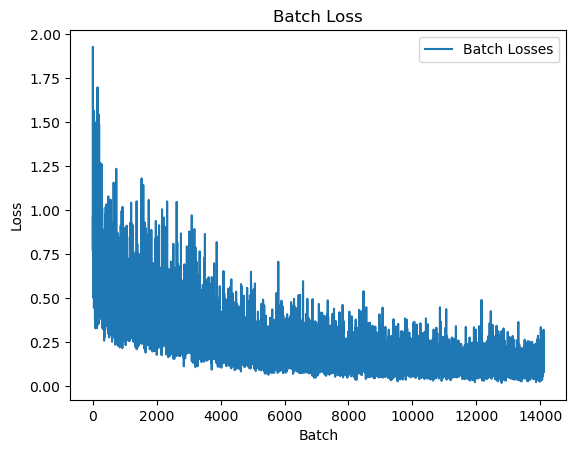

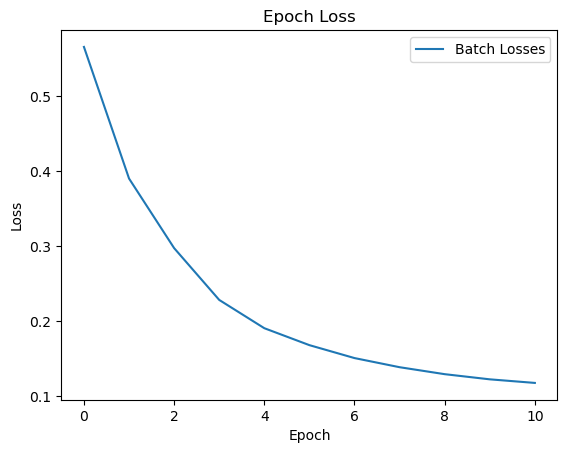

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

if train:
    df_data = pd.DataFrame({'Batch Losses': trainer.batch_losses})
    sns.lineplot(data=df_data)
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Batch Loss')
    plt.show()

    df_data = pd.DataFrame({'Batch Losses': trainer.epoch_losses})
    sns.lineplot(data=df_data)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Epoch Loss')
    plt.show()

# FIND OPTIMAL THRESHOLD

In [39]:
from tqdm import tqdm

class DiceThresholdTester:

    def __init__(
        self, model: nn.Module, data_loader: torch.utils.data.DataLoader
    ):
        self.model = model
        self.data_loader = data_loader
        self.cumulative_mask_pred = []
        self.cumulative_mask_true = []

    def precalculate_prediction(self) -> None:
        sigmoid = nn.Sigmoid()

        for images, mask_true in self.data_loader:
            if mps_device:
                images = images.to(mps_device)

            mask_pred = sigmoid(model.forward(images))

            self.cumulative_mask_pred.append(mask_pred.cpu().detach().numpy())
            self.cumulative_mask_true.append(mask_true.cpu().detach().numpy())

        self.cumulative_mask_pred = np.concatenate(
            self.cumulative_mask_pred, axis=0
        )
        self.cumulative_mask_true = np.concatenate(
            self.cumulative_mask_true, axis=0
        )

        self.cumulative_mask_pred = torch.flatten(
            torch.from_numpy(self.cumulative_mask_pred)
        )
        self.cumulative_mask_true = torch.flatten(
            torch.from_numpy(self.cumulative_mask_true)
        )

    def test_threshold(self, threshold: float) -> float:
        _dice = Dice(use_sigmoid=False)
        after_threshold = np.zeros(self.cumulative_mask_pred.shape)
        after_threshold[self.cumulative_mask_pred[:] > threshold] = 1
        after_threshold[self.cumulative_mask_pred[:] < threshold] = 0
        after_threshold = torch.flatten(torch.from_numpy(after_threshold))
        return _dice(self.cumulative_mask_true, after_threshold).item()

# ============================
dice_threshold_tester = DiceThresholdTester(model, data_loader_validation)
dice_threshold_tester.precalculate_prediction()

thresholds_to_test = [round(x * 0.01, 2) for x in range(101)]

optim_threshold = 0.975
best_dice_score = -1

thresholds = []
dice_scores = []

for t in tqdm(thresholds_to_test, desc="Testing thresholds"):
    dice_score = dice_threshold_tester.test_threshold(t)
    if dice_score > best_dice_score:
        best_dice_score = dice_score
        optim_threshold = t

    thresholds.append(t)
    dice_scores.append(dice_score)

print(f'Best Threshold: {optim_threshold} with dice: {best_dice_score}')
df_threshold_data = pd.DataFrame(
    {'Threshold': thresholds, 'Dice Score': dice_scores}
)

Testing thresholds: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 101/101 [00:30<00:00,  3.32it/s]

Best Threshold: 0.98 with dice: 0.5371877716944333


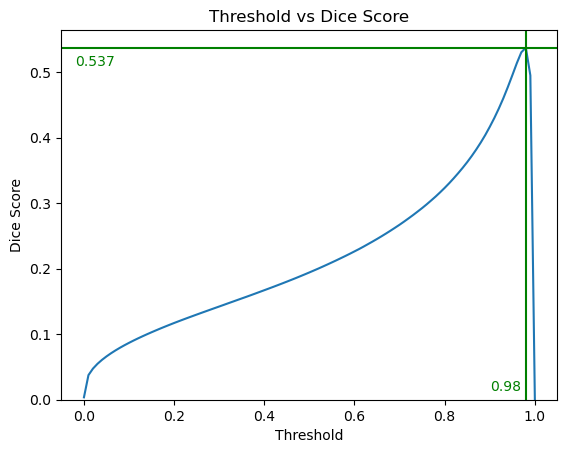

In [40]:
sns.lineplot(data=df_threshold_data, x='Threshold', y='Dice Score')
plt.axhline(y=best_dice_score, color='green')
plt.axvline(x=optim_threshold, color='green')
plt.text(
    -0.02,
    best_dice_score * 0.96,
    f'{best_dice_score:.3f}',
    va='center',
    ha='left',
    color='green',
)
plt.text(
    optim_threshold - 0.01,
    0.02,
    f'{optim_threshold}',
    va='center',
    ha='right',
    color='green',
)
plt.ylim(bottom=0)
plt.title('Threshold vs Dice Score')
plt.show()